# Initialize notebook

In [1]:
import wandb

In [2]:
import lpips
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torchmetrics
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset

In [3]:
import sys
sys.path.append("/home/e/e0425222/CS4243-project")
from utils.dataset_utils.AnimalDataset import AnimalDataset
from utils.train_utils.train_utils import sample_batch, summary
from utils.train_utils.model_utils import Conv2dBlock, GatedConv2dBlock, GatedUpConv2dBlock

/home/e/e0425222/miniconda3/envs/env/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [4]:
train_dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243-project/dataset/frogs_train.txt",
    root_dir_path = "/home/e/e0425222/CS4243-project/dataset/frog_images",
    local_dir_path = "/home/e/e0425222/CS4243-project/dataset/preprocessed_64",
    file_prefix = "frogs_",
    image_dimension = 64,
    concat_mask = True,
    random_noise = False,
    require_init = False,
    drops = [])

valid_dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243-project/dataset/frogs_val.txt",
    root_dir_path = "/home/e/e0425222/CS4243-project/dataset/frog_images",
    local_dir_path = "/home/e/e0425222/CS4243-project/dataset/preprocessed_64",
    file_prefix = "frogs_",
    image_dimension = 64,
    concat_mask = True,
    random_noise = False,
    require_init = False,
    drops = [])

test_dataset = AnimalDataset(index_file_path = "/home/e/e0425222/CS4243-project/dataset/frogs_test.txt",
    root_dir_path = "/home/e/e0425222/CS4243-project/dataset/frog_images",
    local_dir_path = "/home/e/e0425222/CS4243-project/dataset/preprocessed_64",
    file_prefix = "frogs_",
    image_dimension = 64,
    concat_mask = True,
    random_noise = False,
    require_init = False,
    drops = [])


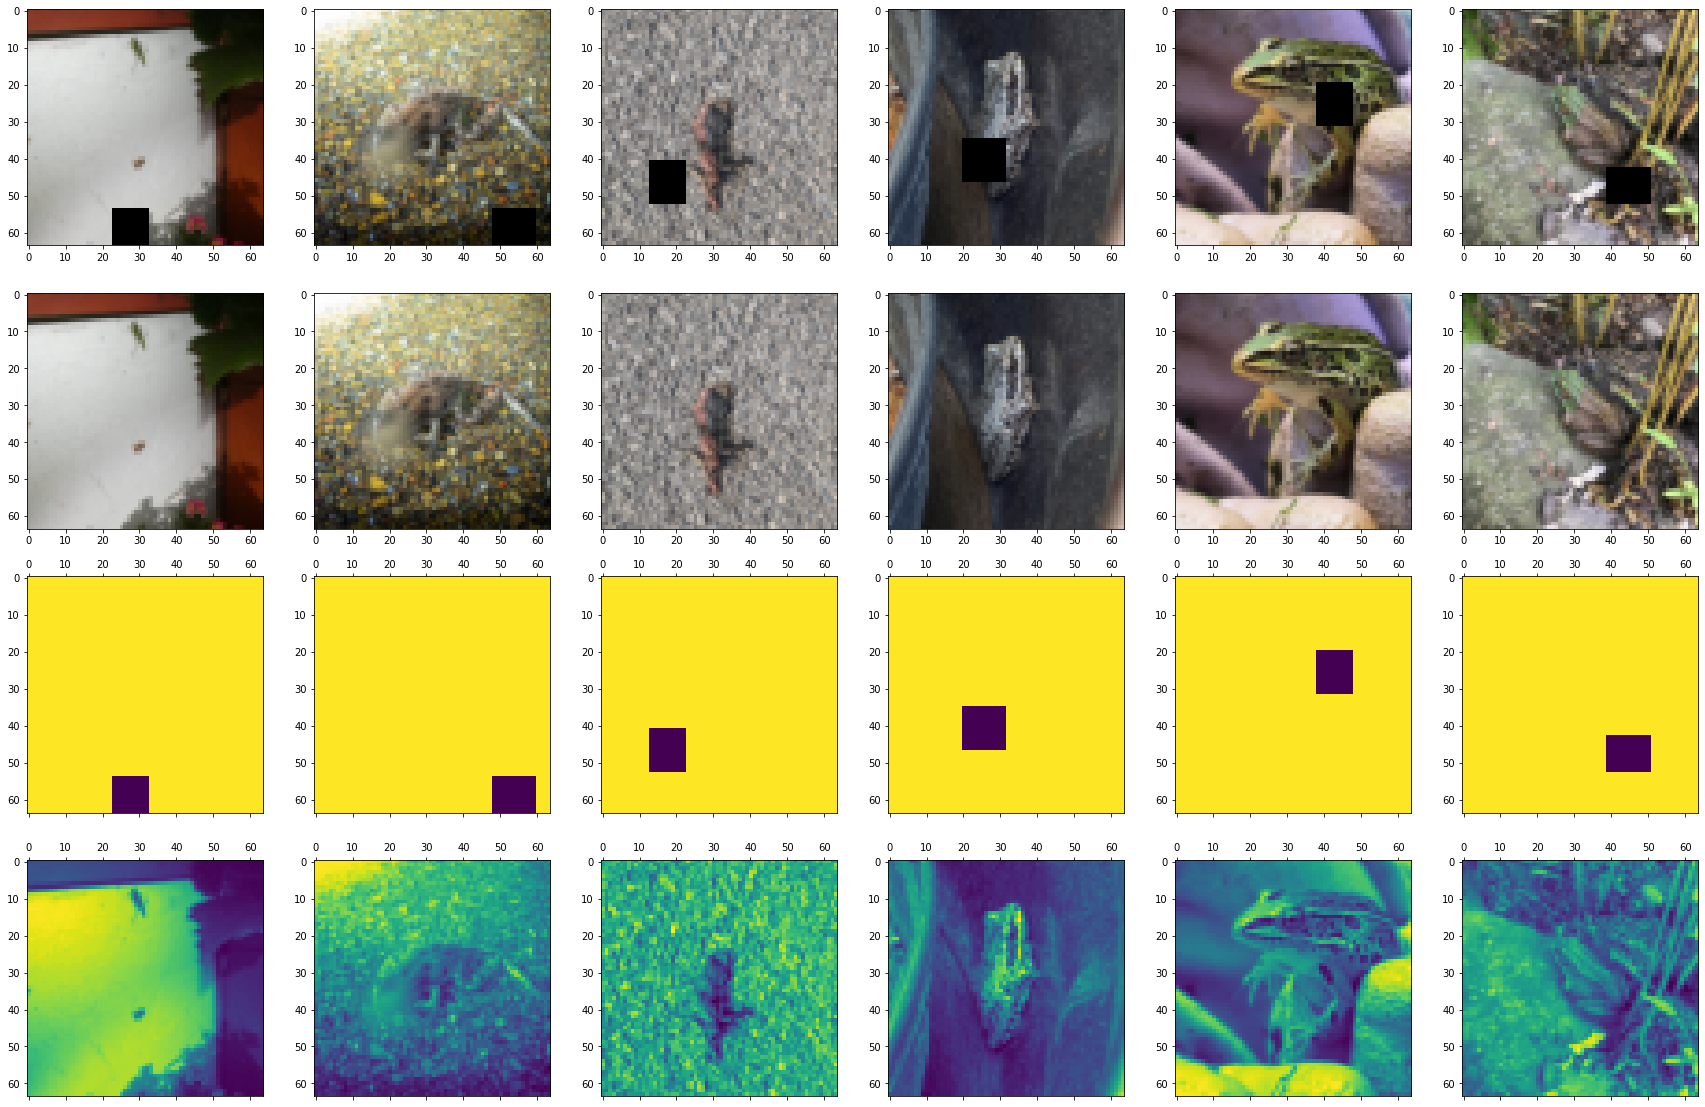

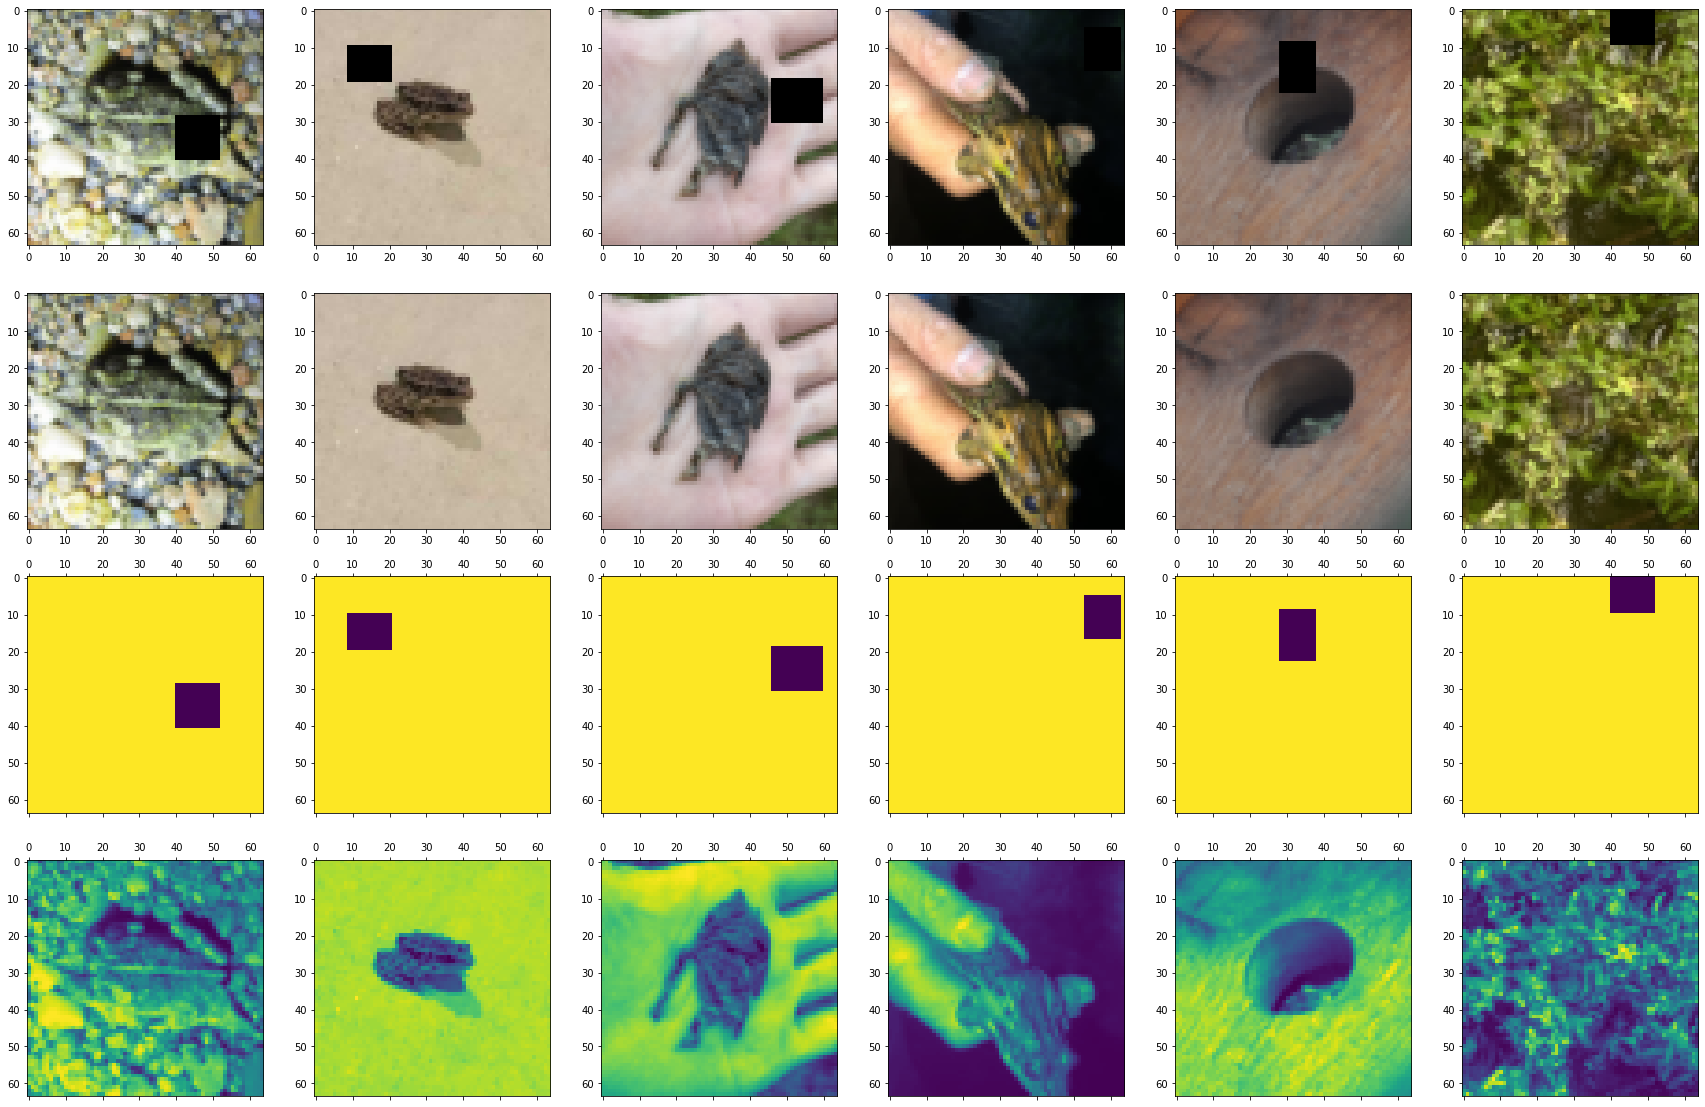

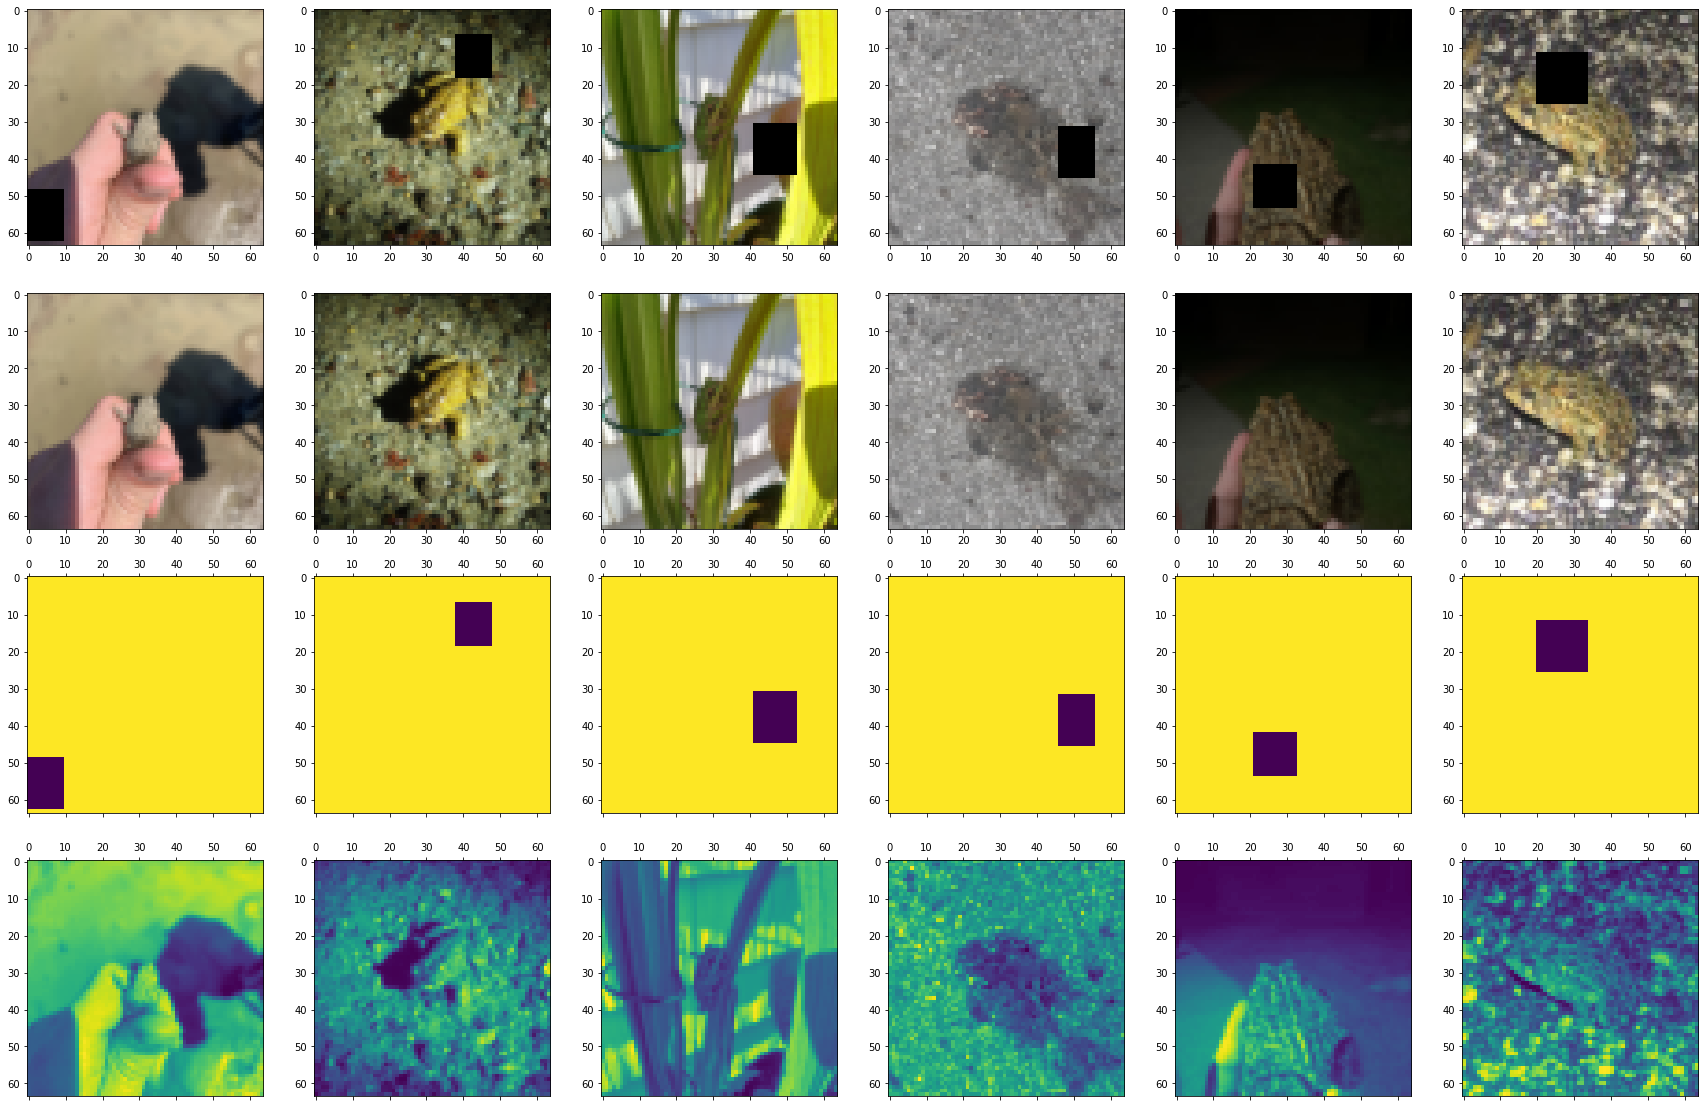

In [5]:
# sanity check 
sample_batch(train_dataset, sample_size = 6, show_gray = True)
sample_batch(valid_dataset, sample_size = 6, show_gray = True)
sample_batch(test_dataset, sample_size = 6, show_gray = True)


# Introduction
This notebook aims to explore how the use of a multi-task learning architecture could improve the image inpainting task. We observe that the generated images are blurry. By adding as an auxiliarry task a grayscale (easier) prediction, the idea is that the image structure will be improved.

# Model experiment


In [17]:
class Generator(nn.Module):

    def __init__(self, input_dim, hidden_dim, activation):
        super(Generator, self).__init__()
        
        # same -> downsample -> same -> downsample
        self.conv0 = GatedConv2dBlock(input_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv1 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv2 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv3 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)

        # 2 x same conv
        self.conv4 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv5 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)

        # 4 x dilated same conv
        self.conv6 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 2, dilation = 2, activation = activation)
        self.conv7 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 4, dilation = 4, activation = activation)
        self.conv8 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 8, dilation = 8, activation = activation)
        self.conv9 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 16, dilation = 16, activation = activation)

        # 2 x same conv
        self.conv10 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv11 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)

        # 2 x up conv for gray
        self.convgray1 = GatedUpConv2dBlock(hidden_dim, hidden_dim, scale_factor = (2,2), kernel_size = 3, stride = 1, padding = 1, dilation = 1, mode = 'nearest')
        self.convgray2 = GatedUpConv2dBlock(hidden_dim, hidden_dim, scale_factor = (2,2), kernel_size = 3, stride = 1, padding = 1, dilation = 1, mode = 'nearest')

        # 2 x down conv for gray for concat
        self.convgray3 = GatedConv2dBlock(1, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.convgray4 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)

        # upsample -> same -> upsample -> same
        self.conv12 = GatedUpConv2dBlock(hidden_dim*2, hidden_dim, scale_factor = (2,2), kernel_size = 3, stride = 1, padding = 1, dilation = 1, mode = 'nearest')
        self.conv13 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)
        self.conv14 = GatedUpConv2dBlock(hidden_dim, hidden_dim, scale_factor = (2,2), kernel_size = 3, stride = 1, padding = 1, dilation = 1, mode = 'nearest')
        self.conv15 = GatedConv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 1, padding = 1, dilation = 1, activation = activation)

        # final
        self.final = nn.Conv2d(hidden_dim, 3, kernel_size = 3, stride = 1, padding = 'same')
        self.gray = nn.Conv2d(hidden_dim, 1, kernel_size = 3, stride = 1, padding = 'same')


    def forward(self, input_tensor, return_adj = False):

        x = self.conv0(input_tensor)
        
        # downsample
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # middle layers
        x = self.conv4(x)
        x = self.conv5(x)

        # dilated conv with residual skips
        x = self.conv6(x) + x
        x = self.conv7(x) + x
        x = self.conv8(x) + x
        x = self.conv9(x) + x

        # middle layers
        x = self.conv10(x)
        x = self.conv11(x)

        # gray prediction
        gray = self.convgray1(x)
        gray = self.convgray2(gray)
        gray = torch.sigmoid(self.gray(gray))

        x_gray = self.convgray3(gray)
        x_gray = self.convgray4(x_gray)

        # upsample using gray
        x = self.conv12(torch.cat([x, x_gray], dim = 1))
        x = self.conv13(x)
        x = self.conv14(x)
        x = self.conv15(x)
        
        # final
        final = self.final(x)

        return final, gray


class Discriminator(nn.Module):

    def __init__(self, input_dim, hidden_dim, input_shape, activation):

        super(Discriminator, self).__init__()

        # 5 layers down
        self.conv0 = Conv2dBlock(input_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv1 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv2 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv3 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)
        self.conv4 = Conv2dBlock(hidden_dim, hidden_dim, kernel_size = 3, stride = 2, padding = 1, dilation = 1, activation = activation)

        # linear to predict classes
        LATENT_H = input_shape//(2**5)
        self.linear = nn.Linear(LATENT_H**2 * hidden_dim, 1)


    def forward(self, input_tensor):
        
        x = self.conv0(input_tensor)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # scores
        x = torch.flatten(x, start_dim = 1)
        x = self.linear(x)

        return x


# Training configuration

In [18]:
MODEL_PARAMS = {
    "description" : """
        Base structure same as the GLCIC model. Middle upsampling layer branches to predict coarse
        gray prediction, which is concatenated to upsampling layers of main branch. 
        Gated convolutions replace all convolutions in the generator.
        """,
    "hidden_dim" : 64,
    "activation" : nn.Mish,
}

SAVE_PATHS = {
    "generator" : "/home/e/e0425222/CS4243-project/active_experiments/EdgeGAN/generator/generator",
    "discriminator" : "/home/e/e0425222/CS4243-project/active_experiments/EdgeGAN/discriminator/discriminator"
}

TRAINING_PARAMS = {
    "num_epochs" : 20,
    "batch_size" : 64, 
    "learning_rate": 1e-4,
    "alpha": 0.1,
    "beta": 0.1,
    "schedule_every" : 5,
    "sample_size" : 16,
    "log_every" : 10,
    "save_paths" : SAVE_PATHS,
}

LOGGING_CONFIG = {
    "model_params" : MODEL_PARAMS,
}
LOGGING_CONFIG.update(TRAINING_PARAMS)

# Experiment intialization

In [19]:
# 1. initialize model
generator = Generator(input_dim = 4, hidden_dim = MODEL_PARAMS["hidden_dim"], activation = MODEL_PARAMS["activation"])
discriminator = Discriminator(input_dim = 3, hidden_dim = MODEL_PARAMS["hidden_dim"], input_shape = 64, activation = MODEL_PARAMS["activation"])

summary(generator)
summary(discriminator)

# 2. device
parallel = True
device = 'cuda:2'  
devices = [2,0,1,3]

if not parallel:
    generator1 = generator.to(device)
    discriminator = discriminator.to(device)
else:
    generator1 = nn.DataParallel(generator, device_ids = devices)
    discriminator = nn.DataParallel(discriminator, device_ids = devices)

# 3. initialize loss functions
recon_loss_function = lambda img, gt, mask : nn.functional.mse_loss(img * (1-mask), gt * (1-mask), reduction = 'none').sum()/(1-mask).sum()
auxilliary_loss_function = nn.functional.binary_cross_entropy
discriminator_loss_function = nn.functional.binary_cross_entropy_with_logits

# 4. initialize metrics
VGG_LPIPS = lpips.LPIPS(net = 'vgg').to(device)
METRICS = {
    "Peak SnR (Whole)" : lambda img, gt, mask : torchmetrics.functional.peak_signal_noise_ratio(img * (1-mask) + gt * mask, gt),
    "L2 loss (Whole)" : lambda img, gt, mask : nn.functional.mse_loss(img * (1-mask) + gt * mask, gt),
    "L2 loss (Mask)" : lambda img, gt, mask : nn.functional.mse_loss(img * (1-mask), gt * (1-mask), reduction = 'sum')/(1-mask).sum(),
    "L1 loss (Whole)" : lambda img, gt, mask : nn.functional.l1_loss(img * (1-mask) + gt * mask, gt),
    "L1 loss (Mask)" : lambda img, gt, mask : nn.functional.l1_loss(img * (1-mask), gt * (1-mask), reduction = 'sum')/(1-mask).sum(),
    "LPIPS (Whole)" : (lambda img, gt, mask : VGG_LPIPS(img * (1-mask) + gt * mask, gt).mean()),
}


# 5. initialize optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr = TRAINING_PARAMS["learning_rate"])
generator_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(generator_optimizer, mode = 'min', factor = 0.5, patience = 1, threshold = 1e-6)

discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr = TRAINING_PARAMS["learning_rate"])
discriminator_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(discriminator_optimizer, mode = 'min', factor = 0.5, patience = 1, threshold = 1e-6)

# 6. wrap into training dictionary
TRAINING_PARAMS["generator_model"] = generator
TRAINING_PARAMS["generator_optimizer"] = generator_optimizer
TRAINING_PARAMS["generator_scheduler"] = generator_scheduler
TRAINING_PARAMS["discriminator_model"] = discriminator
TRAINING_PARAMS["discriminator_optimizer"] = discriminator_optimizer
TRAINING_PARAMS["discriminator_scheduler"] = discriminator_scheduler
TRAINING_PARAMS["discriminator_loss_function"] = discriminator_loss_function
TRAINING_PARAMS["recon_loss_function"] = recon_loss_function
TRAINING_PARAMS["auxilliary_loss_function"] = auxilliary_loss_function


model has 1.41402 million parameters
model has 0.150401 million parameters
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/e/e0425222/miniconda3/envs/env/lib/python3.7/site-packages/lpips/weights/v0.1/vgg.pth


# Initialize logging

In [20]:
wandb.init(project="EdgeGAN", entity="cs4243_project")
wandb.config = LOGGING_CONFIG

wandb.watch(
    (generator, discriminator),
    criterion = None,
    log = 'all',
    log_freq = 1,
    idx = 0, 
    log_graph = False
)


L1 loss (Mask),█▆▅▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
L1 loss (Whole),█▆▅▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
L2 loss (Mask),█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
L2 loss (Whole),█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LPIPS (Whole),█▆▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Peak SnR (Whole),▁▃▄▄▅▅▆▆▆▆▆▆████████████████████████████
loss_aux,▇██████▇▇▇▇▇▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁
loss_discriminator,▇██████▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▄▃▃▃▃▃▂▂▂▂▁
loss_generator,█▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_generator_adv,▁▂▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▆▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss_generator_r,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


[]

# Train

## Train functions

In [21]:

def train_epoch(device, train_dataloader, training_params : dict, metrics : dict, log_wandb = True):
    
    # ===== INITIALIZE =====
    # constants
    RECONSTRUCTION_LOSS = training_params["recon_loss_function"]
    DISCRIMINATOR_LOSS_FUNCTION = training_params["discriminator_loss_function"]
    AUX_LOSS = training_params["auxilliary_loss_function"]

    GENERATOR_OPTIMIZER = training_params["generator_optimizer"]
    DISCRIMINATOR_OPTIMIZER = training_params["discriminator_optimizer"]

    BATCH_EVALUATE_EVERY = 5
    LOG_EVERY = training_params["log_every"]
    SAMPLE_SIZE = training_params["sample_size"]
    BATCH_SIZE = training_params["batch_size"]
    ALPHA = training_params["alpha"]
    BETA = training_params["beta"]

    # models
    generator = training_params["generator_model"].to(device).train()
    discriminator = training_params["discriminator_model"].to(device).train()

    # epoch metrics
    running_results = {list(metrics.keys())[i] : 0.0 for i in range(len(metrics)) } 
    running_results["loss_discriminator"] = 0.0
    running_results["loss_generator"] = 0.0
    running_results["loss_generator_r"] = 0.0
    running_results["loss_generator_adv"] = 0.0
    running_results["loss_aux"] = 0.0


    # ===== TRAIN EPOCH =====
    num_batches = 0
    for _, batch in enumerate(train_dataloader, 1):

            # ===== INITIALIZE =====
            num_batches += 1

            # input and ground truth
            input_batched = batch["image"]
            ground_truth_batched = batch["reconstructed"]
            mask_batched = batch["mask"]
            gray_batched = batch["gray"]

            # sanity check
            assert input_batched.shape[0] == ground_truth_batched.shape[0]

            # move tensors to device
            input_batched = input_batched.to(device)
            ground_truth_batched = ground_truth_batched.to(device)
            mask_batched = mask_batched.to(device)
            gray_batched = gray_batched.to(device)

            # set the gradients to zeros
            GENERATOR_OPTIMIZER.zero_grad()
            DISCRIMINATOR_OPTIMIZER.zero_grad()

            # reshape to channel first
            input_batched = input_batched.permute(0, 3, 1, 2)
            ground_truth_batched = ground_truth_batched.permute(0, 3, 1, 2)
            mask_batched = mask_batched.permute(0, 3, 1, 2)
            gray_batched = gray_batched.unsqueeze(1)

            # ===== FORWARD PASS =====

            # 1. train discriminator
            
            # 1.1 generate images
            input_batched.requires_grad_()
            output_batched, _ = generator(input_batched)

            # 1.2 splice with ground truth
            spliced_batched = ((1-mask_batched) * output_batched) + (mask_batched * ground_truth_batched) 

            # 1.3 feed into discriminator
            label_real = torch.ones(BATCH_SIZE, 1).to(device)
            label_fake = torch.zeros(BATCH_SIZE, 1).to(device)

            pred_real = discriminator(ground_truth_batched)
            loss_real = DISCRIMINATOR_LOSS_FUNCTION(pred_real, label_real)

            pred_fake = discriminator(spliced_batched)
            loss_fake = DISCRIMINATOR_LOSS_FUNCTION(pred_fake, label_fake)
            loss_d = ALPHA * (loss_real + loss_fake)
            loss_d.backward()
            DISCRIMINATOR_OPTIMIZER.step()

            # 2. train generator (reconstruction, adverserial)
            # 2.1 forward pass by generator to produce images, splice them
            output_batched, gray = generator(input_batched)
            spliced_batched = ((1-mask_batched) * output_batched) + (mask_batched * ground_truth_batched) 
            
            # 2.2 reconstruction loss
            loss_g_reconstruction = RECONSTRUCTION_LOSS(output_batched, ground_truth_batched, mask_batched)

            # 2.3 adverserial loss
            label_real = torch.ones(BATCH_SIZE, 1).to(device)
            pred_adverserial = discriminator(spliced_batched)
            loss_g_adverserial = DISCRIMINATOR_LOSS_FUNCTION(pred_adverserial, label_real) # want it to classify all as real

            # 2.4 auxilliary loss
            loss_aux = AUX_LOSS(gray, gray_batched)

            # 2.5 backprop
            loss_g = loss_g_reconstruction + ALPHA * loss_g_adverserial + BETA * loss_aux
            loss_g.backward()
            GENERATOR_OPTIMIZER.step()

            # ===== COMPUTE STATISTICS, USING TORCH METRICS =====  
            # 1. compute losses

            running_results["loss_generator"] += loss_g.detach().item()
            running_results["loss_generator_r"] += loss_g_reconstruction.detach().item()
            running_results["loss_generator_adv"] += loss_g_adverserial.detach().item()
            running_results["loss_discriminator"] += loss_d.detach().item()
            running_results["loss_aux"] += loss_aux.detach().item()


            # 2. for each key, compute, add item to results dictionary (take average of 2 generators)
            for key, func in metrics.items():
                running_results[key] += func(output_batched, ground_truth_batched, mask_batched).detach().item()

            # 3. log with wandb
            if log_wandb and (num_batches % LOG_EVERY == 0):

                # generator 1
                batched_predictions = torch.cat([
                    input_batched[:SAMPLE_SIZE, 0:3,:,:], # can be 4 channels
                    ground_truth_batched[:SAMPLE_SIZE,:,:,:],  # 3 channels
                    spliced_batched[:SAMPLE_SIZE,:,:,:]], dim = 0) 
                
                image_array = torchvision.utils.make_grid(batched_predictions, nrow = SAMPLE_SIZE, padding = 50)
                images = wandb.Image(
                    image_array, 
                    caption = "1st row: Damaged, 2nd row: Ground truth, 3rd row: spliced")
                
                gray_predictions = torch.cat([gray[:SAMPLE_SIZE], gray_batched[:SAMPLE_SIZE]], dim = 0)
                gray_array = torchvision.utils.make_grid(gray_predictions, nrow = SAMPLE_SIZE, padding = 50)
                gray_images = wandb.Image(
                    gray_array, 
                    caption = "Gray")

                # log images and some metadata
                wandb.log( {
                    "generator_train_images" : images,
                    "gray_images" : gray_images,
                    "lr_generator" : GENERATOR_OPTIMIZER.param_groups[0]['lr'],
                    "lr_discriminator" : DISCRIMINATOR_OPTIMIZER.param_groups[0]['lr']

                })

                # log all metrics
                wandb.log(
                    {key : item/num_batches for key, item in running_results.items()}
                )
        
            # ===== HOUSEKEEPING =====
            del loss_g
            del loss_d
            del input_batched

            # print results every some batches
            if num_batches % BATCH_EVALUATE_EVERY == 0: 

                args = ""
                for key, _ in running_results.items():
                    args += key + ": " + str(running_results[key]/num_batches) + "   "
                print(f"\r{num_batches}/{len(train_dataloader)}: " + args, end = '', flush = True)

    # normalise numbers by batch
    for key, _ in running_results.items():
        running_results[key] /= num_batches

    return running_results




In [22]:
def evaluate_epoch(device, validation_dataloader, training_params : dict, metrics : dict, log_wandb = True):

    # ===== INITIALIZE =====
    # models
    generator = training_params["generator_model"].to(device).eval()

    # constants
    BATCH_SIZE = training_params["batch_size"]
    SAMPLE_SIZE = training_params["sample_size"]

    # epoch statistics
    running_results = {list(metrics.keys())[i] : 0.0 for i in range(len(metrics)) } 

    # ===== EVALUATE EPOCH =====

    with torch.no_grad():
        batches = 0
        for index, batch in enumerate(validation_dataloader, 1):
            
            batches += 1

            # input and ground truth
            input_batched = batch["image"]
            ground_truth_batched = batch["reconstructed"]
            mask_batched = batch["mask"]
            gray_batched = batch["gray"]

            # move tensors to device
            input_batched = input_batched.to(device)
            ground_truth_batched = ground_truth_batched.to(device)
            mask_batched = mask_batched.to(device)
            gray_batched = gray_batched.to(device)

            # ===== FORWARD PASS =====

            # 1. reshape to channel first
            input_batched = input_batched.permute(0, 3, 1, 2)
            ground_truth_batched = ground_truth_batched.permute(0, 3, 1, 2)
            mask_batched = mask_batched.permute(0, 3, 1, 2)
            gray_batched = gray_batched.unsqueeze(1)

            # 2. predict    
            output_batched, gray = generator(input_batched)
            spliced_batched = ((1-mask_batched) * output_batched) + (mask_batched * ground_truth_batched) 

            # 3. evaluate
            for key, func in metrics.items():
                running_results[key] += func(output_batched, ground_truth_batched, mask_batched).detach().item()

            args = ""
            for key, _ in running_results.items():
                args += key + ": " + str(running_results[key]/batches) + "   "
            print(f"\r{batches}/{len(validation_dataloader)}: " + args, end = '', flush = True)

            # 4. log 
            if log_wandb:

                # generator 1
                batched_predictions = torch.cat([
                    input_batched[:SAMPLE_SIZE, 0:3,:,:], # can be 4 channels
                    ground_truth_batched[:SAMPLE_SIZE,:,:,:],  # 3 channels
                    spliced_batched[:SAMPLE_SIZE,:,:,:]], dim = 0) 
                image_array = torchvision.utils.make_grid(batched_predictions, nrow = SAMPLE_SIZE, padding = 50)
                images = wandb.Image(
                    image_array, 
                    caption = "1st row: Damaged, 2nd row: Ground truth, 3rd row: spliced")
                gray_predictions = torch.cat([gray[:SAMPLE_SIZE], gray_batched[:SAMPLE_SIZE]], dim = 0)
                gray_array = torchvision.utils.make_grid(gray_predictions, nrow = SAMPLE_SIZE, padding = 50)
                gray_images = wandb.Image(
                    gray_array, 
                    caption = "Gray")
                
                # log images and some metadata
                wandb.log( {
                    "generator_val_images" : images,
                    "generator_val_gray" : gray_images
                })

                # log all metrics
                wandb.log(
                    {f"val_{key}" : item/batches for key, item in running_results.items()}
                )

    # normalise numbers by batch
    for key, _ in running_results.items():
        running_results[key] /= batches

    return running_results


In [23]:
def train_evaluate(device, train_dataset, validation_dataset, training_params: dict, metrics: dict, start_epoch = 0, log_wandb = True):

    # ===== INITIALIZE =====
    # constants
    NUM_EPOCHS = training_params["num_epochs"]
    BATCH_SIZE = training_params["batch_size"]
    GENERATOR_SCHEDULER = training_params["generator_scheduler"]
    DISCRIMINATOR_SCHEDULER = training_params["discriminator_scheduler"]
    SAVE_PATHS = training_params["save_paths"]
    NUM_WORKERS = 2
    START_EPOCH = start_epoch

    # models for saving
    generator = training_params["generator_model"].to(device).train()
    discriminator = training_params["discriminator_model"].to(device).train()

    # variable losses
    train_results = {list(metrics.keys())[i] : [] for i in range(len(metrics)) } 

    train_results["loss_discriminator"] = []
    train_results["loss_generator"] = []
    train_results["loss_generator_r"] = []
    train_results["loss_generator_adv"] = []
    train_results["loss_aux"] = []

    eval_results = {list(metrics.keys())[i] : [] for i in range(len(metrics)) } 

    # dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS, drop_last = True)
    validation_dataloader = DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = NUM_WORKERS, drop_last = True)

    # ===== TRAIN =====
    for epoch in range(NUM_EPOCHS):

        start = time.time()

        # train
        print(f"\n===== Epoch: {START_EPOCH + epoch + 1} ===== ")

        # train every epoch
        results = train_epoch(device, train_dataloader, training_params, metrics, log_wandb = log_wandb)
        for key, val in results.items():
            train_results[key].append(val)

        # evaluate every epoch
        print()
        results = evaluate_epoch(device, validation_dataloader, training_params, metrics, log_wandb = log_wandb)
        for key, val in results.items():
            eval_results[key].append(val)

        # ===== EPOCH RESULTS =====
        print(f"\nCompleted epoch {START_EPOCH + epoch + 1}! Took {(time.time() - start)/60} min")

        # ===== HOUSEKEEPING =====

        # scheduler every epoch
        if DISCRIMINATOR_SCHEDULER is not None:
            DISCRIMINATOR_SCHEDULER.step(eval_results["L1 loss (Mask)"][epoch])
        if GENERATOR_SCHEDULER is not None:
            GENERATOR_SCHEDULER.step(eval_results["L1 loss (Mask)"][epoch])
            
        # save every epoch
        SAVE = f"{SAVE_PATHS['generator']}_epoch{START_EPOCH + epoch + 1}.pt"
        torch.save(generator.state_dict(), SAVE)
        SAVE = f"{SAVE_PATHS['discriminator']}_epoch{START_EPOCH + epoch + 1}.pt"
        torch.save(discriminator.state_dict(), SAVE)  

        print("Saved models!")

    return train_results, eval_results

## Train

In [24]:
torch.autograd.set_detect_anomaly(True)

train_evaluate(device, train_dataset, valid_dataset, TRAINING_PARAMS, METRICS, start_epoch = 0, log_wandb = True)


===== Epoch: 1 ===== 
155/156: Peak SnR (Whole): 29.277857558957994   L2 loss (Whole): 0.0016115147196086904   L2 loss (Mask): 0.1401076029625631   L1 loss (Whole): 0.005326949349874931   L1 loss (Mask): 0.4624389313882397   LPIPS (Whole): 0.053966081839415335   loss_discriminator: 0.1396170355619923   loss_generator: 0.27787070697353733   loss_generator_r: 0.1401076029625631   loss_generator_adv: 0.6994666791731311   loss_aux: 0.6781643129164173       
15/15: Peak SnR (Whole): 31.02380510965983   L2 loss (Whole): 0.0007896245496037106   L2 loss (Mask): 0.06857747261722882   L1 loss (Whole): 0.004040810605511069   L1 loss (Mask): 0.35076634883880614   LPIPS (Whole): 0.04227509597937266     
Completed epoch 1! Took 2.991753335793813 min
Saved models!

===== Epoch: 2 ===== 
155/156: Peak SnR (Whole): 31.325940593596428   L2 loss (Whole): 0.0007389911792180952   L2 loss (Mask): 0.06397494945314623   L1 loss (Whole): 0.0038891891783644113   L1 loss (Mask): 0.33669074331560445   LPIPS (Who

({'Peak SnR (Whole)': [29.27954473862281,
   31.32818142573039,
   31.698033883021427,
   32.0985385454618,
   32.35513890095246,
   32.52568808580056,
   32.42898961825249,
   32.556058052258614,
   32.56101950620994,
   32.66209840774536,
   32.702854572198326,
   32.70182053248087,
   32.674000984583145,
   32.86363498981182,
   32.95414077318632,
   33.0496027530768,
   33.0690212005224,
   33.126470724741615,
   33.16430590702937,
   33.21517222966903],
  'L2 loss (Whole)': [0.001608253474189088,
   0.0007386124276448614,
   0.0006792718385650704,
   0.0006178146523336928,
   0.0005830430993974472,
   0.000560663569791732,
   0.0005742659906480605,
   0.0005563667073147371,
   0.000555690789695244,
   0.000543070346257315,
   0.0005376637530459377,
   0.0005378620646810398,
   0.0005411202976411472,
   0.0005185716829892511,
   0.000507624635550504,
   0.0004963156901888,
   0.0004946405432957152,
   0.0004880383684604357,
   0.00048283840460965457,
   0.0004779551232693335],
  'L

In [25]:
torch.autograd.set_detect_anomaly(True)

train_evaluate(device, train_dataset, valid_dataset, TRAINING_PARAMS, METRICS, start_epoch = 20, log_wandb = True)


===== Epoch: 21 ===== 
155/156: Peak SnR (Whole): 33.271227510513796   L2 loss (Whole): 0.00047267807174413914   L2 loss (Mask): 0.0409619826462961   L1 loss (Whole): 0.002933028691838826   L1 loss (Mask): 0.2542218523640786   LPIPS (Whole): 0.022844927553688325   loss_discriminator: 0.1265123216375228   loss_generator: 0.18614163302606151   loss_generator_r: 0.0409619826462961   loss_generator_adv: 0.8374137113171239   loss_aux: 0.6143827688309454         
15/15: Peak SnR (Whole): 33.34378890991211   L2 loss (Whole): 0.00046374925683873394   L2 loss (Mask): 0.039804140975077944   L1 loss (Whole): 0.002906671864911914   L1 loss (Mask): 0.2493341237306595   LPIPS (Whole): 0.02263880558311939      
Completed epoch 21! Took 2.789797532558441 min
Saved models!

===== Epoch: 22 ===== 
155/156: Peak SnR (Whole): 33.169163365517896   L2 loss (Whole): 0.00048260973942946763   L2 loss (Mask): 0.041818487932605126   L1 loss (Whole): 0.002964646505912946   L1 loss (Mask): 0.2568594428800767   LP

wandb: Network error (ReadTimeout), entering retry loop.


155/156: Peak SnR (Whole): 33.31583643267231   L2 loss (Whole): 0.0004671299317476129   L2 loss (Mask): 0.04048330408911551   L1 loss (Whole): 0.0029030753615041896   L1 loss (Mask): 0.2515938078203509   LPIPS (Whole): 0.02225584724257069   loss_discriminator: 0.12578298161106724   loss_generator: 0.18510657164358324   loss_generator_r: 0.04048330408911551   loss_generator_adv: 0.8330849739813035   loss_aux: 0.6131476740683278        
15/15: Peak SnR (Whole): 33.52766596476237   L2 loss (Whole): 0.00044339801728104553   L2 loss (Mask): 0.03828794434666634   L1 loss (Whole): 0.0028359831776469946   L1 loss (Mask): 0.24487594564755757   LPIPS (Whole): 0.021515421320994696   
Completed epoch 30! Took 3.210110553105672 min
Saved models!

===== Epoch: 31 ===== 
155/156: Peak SnR (Whole): 33.37026017712009   L2 loss (Whole): 0.00046149209412115237   L2 loss (Mask): 0.04009193740785122   L1 loss (Whole): 0.0028810475171814043   L1 loss (Mask): 0.2503450055276194   LPIPS (Whole): 0.02210936916

({'Peak SnR (Whole)': [33.26970980717586,
   33.1696493442242,
   33.196624499100906,
   33.27881512275109,
   33.32313477687347,
   33.29205997173603,
   33.30463755436433,
   33.276129502516525,
   33.27421256823418,
   33.31696683932574,
   33.36615660251715,
   33.334072712140205,
   33.34022899774405,
   33.3342107626108,
   33.40105971311912,
   33.34207286590185,
   33.29344058648134,
   33.36007211147211,
   33.334061512580284,
   33.342096035297104],
  'L2 loss (Whole)': [0.0004728104775914779,
   0.0004825288493660852,
   0.0004807149796248175,
   0.000470907092489935,
   0.0004665922115703161,
   0.00046986248791934206,
   0.00046800678739180934,
   0.000471066452379231,
   0.0004716275516563119,
   0.0004669815695169979,
   0.0004619257834304172,
   0.00046489342434469086,
   0.0004640802691051832,
   0.0004649407016516377,
   0.00045726291883068206,
   0.00046477223916624027,
   0.00046899717656346277,
   0.0004617278076087435,
   0.0004650469123496292,
   0.00046410619073

In [26]:
# train_epoch(device, DataLoader(train_dataset, batch_size = 16), TRAINING_PARAMS, METRICS, log_wandb = True)
# evaluate_epoch(device, DataLoader(valid_dataset, batch_size = 16),, TRAINING_PARAMS, metrics, log_wandb = True)